# 1 - Data Exploration

## 1-a Read Data and Make DataFrame

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing as pp
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import sklearn.metrics as met
import statsmodels.api as sm
import warnings
from tqdm import tqdm

warnings.filterwarnings(action="ignore")


df = pd.read_csv("./OnlineNewsPopularityDataset.csv")

X = df.drop(['url', ' timedelta', ' shares'], 1)
y = df[' shares']

## 1-b Descriptive Statictics of All Features 

In [2]:
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


## 1-c Features Correlation

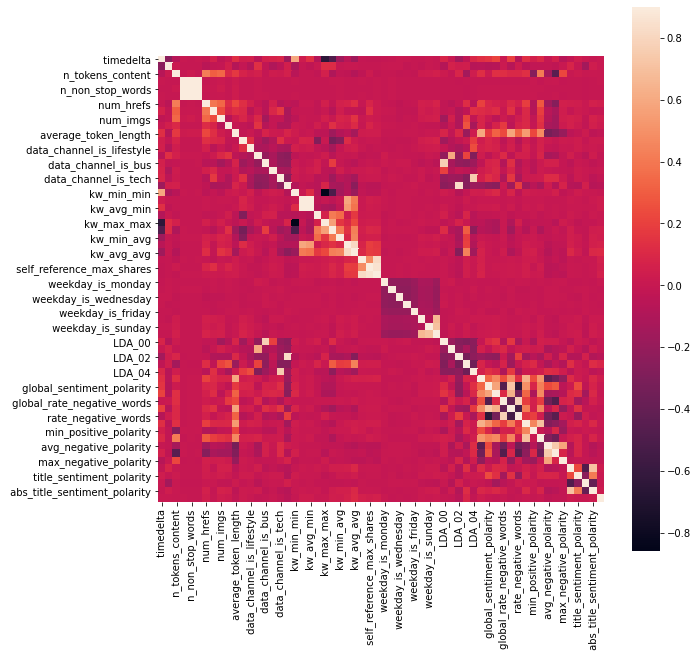

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), annot=False, vmax=0.9, square=True)

# 2 - Building a Regression Model

## 2-a Features preprocessing

### Log scale share value 
Standard deviation of shares value is too large. 
Therefore, convert it into log scale.

#### Before scaled

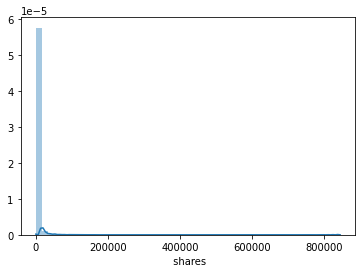

In [4]:
sns.distplot(y, hist=True)

#### After scaled

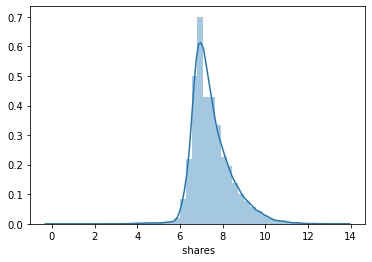

In [5]:
y = np.log(y)
sns.distplot(y, hist=True)

## 2-b Adding non-linear features predictors and interactions

In [6]:
def PolynomialFeatures_labeled(input_df,power):
    poly = pp.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

In [7]:
# Add degree 2 term
X_polynomial = PolynomialFeatures_labeled(X, 2)
X_polynomial

,Constant Term,n_tokens_title^1,n_tokens_content^1,n_unique_tokens^1,n_non_stop_words^1,n_non_stop_unique_tokens^1,num_hrefs^1,num_self_hrefs^1,num_imgs^1,num_videos^1,...,title_subjectivity^2,title_subjectivity^1 x title_sentiment_polarity^1,title_subjectivity^1 x abs_title_subjectivity^1,title_subjectivity^1 x abs_title_sentiment_polarity^1,title_sentiment_polarity^2,title_sentiment_polarity^1 x abs_title_subjectivity^1,title_sentiment_polarity^1 x abs_title_sentiment_polarity^1,abs_title_subjectivity^2,abs_title_subjectivity^1 x abs_title_sentiment_polarity^1,abs_title_sentiment_polarity^2
0,1.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.250000,-0.093750,0.000000,0.093750,0.035156,-0.000000,-0.035156,0.000000,0.000000,0.035156
1,1.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
2,1.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
3,1.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000
4,1.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.206612,0.061983,0.020661,0.061983,0.018595,0.006198,0.018595,0.002066,0.006198,0.018595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39639,1.0,11.0,346.0,0.529052,1.0,0.684783,9.0,7.0,1.0,1.0,...,0.010000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,0.000000
39640,1.0,12.0,328.0,0.696296,1.0,0.885057,9.0,7.0,3.0,48.0,...,0.090000,0.300000,0.060000,0.300000,1.000000,0.200000,1.000000,0.040000,0.200000,1.000000
39641,1.0,10.0,442.0,0.516355,1.0,0.644128,24.0,1.0,12.0,1.0,...,0.206612,0.061983,0.020661,0.061983,0.018595,0.006198,0.018595,0.002066,0.006198,0.018595
39642,1.0,6.0,682.0,0.539493,1.0,0.692661,10.0,1.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000


## 2-c Features selection

### Least Absolute Shrinkage and Selection Operator (LASSO)
Since we have 1770 features now, we can't apply wraper method like forward selection due to time complexity. However, embedded method LASSO can select features in model training phase. The optimization objective for Lasso is below. 
$$(1 / (2 * n_{samples})) * ||y - Xw||^2_2 + {\alpha} * ||w||_1$$
It is linear model trained with L1 prior as regularizer. The coefficient of unnecessary features goes zero naturally.
Alpha is key hyperparameter of LASSO. We should find optimal alpha. 

#### Applying training/testing paradigm with features selection

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_polynomial,y, test_size=0.3, random_state=10)

훈련 데이터:  (27750, 58)
검증 데이터:  (11894, 58)


100%|██████████| 15/15 [07:25<00:00, 29.72s/it]


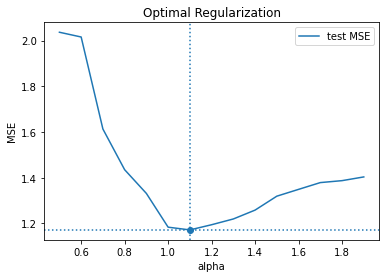

In [62]:
alphas = np.arange(0.5, 2.0, 0.1)

test_scores = []

for alpha in tqdm(alphas):
    model = Lasso(alpha=alpha)
    model.fit(X_poly_train, y_poly_train)
    y_pred = model.predict(X_poly_test)
    test_score = met.mean_squared_error(y_poly_test, y_pred)
    test_scores.append(test_score)
    
optimal_alpha = alphas[np.argmin(test_scores)]
optimal_score = np.min(test_scores)
plt.plot(alphas, test_scores, "-", label="test MSE")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("Optimal Regularization")
plt.ylabel('MSE')
plt.xlabel('alpha')
plt.legend()
plt.show()

In [63]:
print("optimal alpha", optimal_alpha)
print("optimal score", optimal_score)

optimal alpha 1.0999999999999999
optimal score 1.171476474204449


#### Applying cross-validation paradigm with features selection

100%|██████████| 15/15 [46:42<00:00, 186.85s/it]


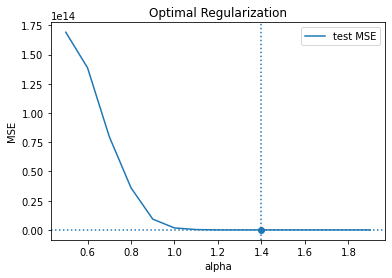

In [65]:
test_scores = []

for alpha in tqdm(alphas):
    model = Lasso(alpha=alpha)
    # Implemented cross_val_score uses neg_mean_squared_error because it represents score which is higher is better. Thus, just negative it.
    test_score = -np.mean(cross_val_score(model, X_polynomial, y, scoring="neg_mean_squared_error", cv=4))
    test_scores.append(test_score)
    
optimal_alpha = alphas[np.argmin(test_scores)]
optimal_score = np.min(test_scores)
plt.plot(alphas, test_scores, "-", label="test MSE")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("Optimal Regularization")
plt.ylabel('MSE')
plt.xlabel('alpha')
plt.legend()
plt.show()


In [66]:
print("optimal alpha", optimal_alpha)
print("optimal score", optimal_score)

optimal alpha 1.4
optimal score 5159176522.870532


#### Applying the bootstrapping paradigm with features selection

 44%|████▍     | 155/350 [00:23<00:31,  6.27it/s]


 88%|████████▊ | 309/350 [00:47<00:06,  6.10it/s]


 32%|███▏      | 113/350 [00:17<00:37,  6.39it/s]


 76%|███████▋  | 267/350 [00:40<00:13,  6.14it/s]


 20%|██        | 71/350 [00:10<00:44,  6.32it/s]


 65%|██████▍   | 226/350 [00:34<00:19,  6.51it/s]


  8%|▊         | 29/350 [00:04<00:51,  6.20it/s]


 53%|█████▎    | 184/350 [00:28<00:27,  6.05it/s]


 97%|█████████▋| 338/350 [00:51<00:01,  6.58it/s]


 41%|████      | 142/350 [00:21<00:32,  6.44it/s]


 85%|████████▍ | 296/350 [00:44<00:08,  6.74it/s]


 29%|██▊       | 100/350 [00:14<00:37,  6.64it/s]


 73%|███████▎  | 254/350 [00:37<00:14,  6.74it/s]


 17%|█▋        | 58/350 [00:08<00:45,  6.42it/s]


 61%|██████    | 213/350 [00:31<00:22,  6.20it/s]


  5%|▍         | 16/350 [00:02<00:50,  6.59it/s]


 49%|████▉     | 172/350 [00:25<00:28,  6.35it/s]


 93%|█████████▎| 326/350 [00:48<00:03,  6.57it/s]


 37%|███▋      | 130/350 [00:19<00:32,  6.79it/s]


 81%|████████  | 284/350 [00:42<00:09,  6.62it/s]


 25%|██▌       | 88/350 [00:13<00:40,  6.54it/s]


 69%|██████▉   | 242/350 [00:36<00:15,  6.87it/s]


 13%|█▎        | 45/350 [00:06<00:46,  6.57it/s]


 57%|█████▋    | 200/350 [00:29<00:22,  6.78it/s]


  1%|          | 2/350 [00:00<00:56,  6.13it/s]


 45%|████▌     | 158/350 [00:23<00:28,  6.79it/s]


 89%|████████▉ | 312/350 [00:46<00:05,  6.67it/s]


 33%|███▎      | 116/350 [00:17<00:34,  6.84it/s]


 77%|███████▋  | 270/350 [00:39<00:11,  6.90it/s]


 21%|██        | 74/350 [00:10<00:39,  6.91it/s]


 65%|██████▌   | 229/350 [00:34<00:17,  6.92it/s]


  9%|▉         | 32/350 [00:04<00:53,  5.95it/s]


 53%|█████▎    | 187/350 [00:27<00:23,  6.86it/s]


 97%|█████████▋| 341/350 [00:50<00:01,  6.71it/s]


100%|██████████| 15/15 [13:05<00:00, 52.40s/it]


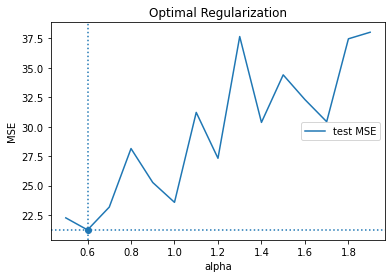

In [144]:
test_scores = []
for alpha in tqdm(alphas):
    sampled_score = []
    for i in tqdm(range(350)):
        model = Lasso(alpha=alpha)
        X_resampled, y_resampled = resample(X_polynomial, y, n_samples=100)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_resampled)
        sampled_score.append(met.mean_squared_error(y_resampled, y_pred))
    test_scores.append(np.mean(sampled_score))
    
optimal_alpha = alphas[np.argmin(test_scores)]
optimal_score = np.min(test_scores)
plt.plot(alphas, test_scores, "-", label="test MSE")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("Optimal Regularization")
plt.ylabel('MSE')
plt.xlabel('alpha')
plt.legend()
plt.show()    

In [145]:
print("optimal alpha", optimal_alpha)
print("optimal score", optimal_score)

optimal alpha 0.6
optimal score 21.22919182953983


# 3 - Regression Model Evaluation

## 3-a Report most important features
The features with non-zero coefficient are selected features. Proper alpha of LASSO is selected to 0.6, 1.1, 1.4 at the section 2.

#### alpha = 0.6

In [150]:
model_1 = Lasso(alpha=0.6)
model_1.fit(X_polynomial, y)
model_1.coef_

array([   0.        ,  436.84815879,   -1.751519  , ...,    0.        ,
       1149.07506833,  538.65349238])

In [151]:
feature_idx_1 = np.where(model_1.coef_ != 0)
print(len(feature_idx_1[0]))
feature_list_1 = []
for i in feature_idx_1[0]:
    feature_list_1.append(X_polynomial.columns[i])

print(feature_list_1)

1293
[' n_tokens_title^1', ' n_tokens_content^1', ' n_unique_tokens^1', ' n_non_stop_words^1', ' n_non_stop_unique_tokens^1', ' num_hrefs^1', ' num_self_hrefs^1', ' num_imgs^1', ' num_videos^1', ' num_keywords^1', ' data_channel_is_entertainment^1', ' data_channel_is_bus^1', ' data_channel_is_world^1', ' kw_min_min^1', ' kw_max_min^1', ' kw_avg_min^1', ' kw_min_max^1', ' kw_max_max^1', ' kw_avg_max^1', ' kw_min_avg^1', ' kw_max_avg^1', ' kw_avg_avg^1', ' self_reference_min_shares^1', ' self_reference_max_shares^1', ' self_reference_avg_sharess^1', ' weekday_is_monday^1', ' weekday_is_wednesday^1', ' weekday_is_thursday^1', ' weekday_is_friday^1', ' title_subjectivity^1', ' abs_title_subjectivity^1', ' n_tokens_title^2', ' n_tokens_title^1 x  n_tokens_content^1', ' n_tokens_title^1 x  n_unique_tokens^1', ' n_tokens_title^1 x  n_non_stop_words^1', ' n_tokens_title^1 x  n_non_stop_unique_tokens^1', ' n_tokens_title^1 x  num_hrefs^1', ' n_tokens_title^1 x  num_self_hrefs^1', ' n_tokens_tit

#### alpha = 1.1

In [152]:
model_2 = Lasso(alpha=1.1)
model_2.fit(X_polynomial, y)
model_2.coef_

array([  0.        , 501.25527431,  -1.57802482, ...,   0.        ,
         0.        ,   0.        ])

In [153]:
feature_idx_2 = np.where(model_2.coef_ != 0)
print(len(feature_idx_2[0]))
feature_list_2 = []
for i in feature_idx_2[0]:
    feature_list_2.append(X_polynomial.columns[i])

print(feature_list_2)

1206
[' n_tokens_title^1', ' n_tokens_content^1', ' n_non_stop_words^1', ' num_hrefs^1', ' num_self_hrefs^1', ' num_imgs^1', ' num_videos^1', ' num_keywords^1', ' data_channel_is_entertainment^1', ' data_channel_is_bus^1', ' kw_min_min^1', ' kw_max_min^1', ' kw_avg_min^1', ' kw_min_max^1', ' kw_max_max^1', ' kw_avg_max^1', ' kw_min_avg^1', ' kw_max_avg^1', ' kw_avg_avg^1', ' self_reference_min_shares^1', ' self_reference_max_shares^1', ' self_reference_avg_sharess^1', ' weekday_is_monday^1', ' weekday_is_thursday^1', ' weekday_is_friday^1', ' title_subjectivity^1', ' abs_title_subjectivity^1', ' n_tokens_title^2', ' n_tokens_title^1 x  n_tokens_content^1', ' n_tokens_title^1 x  n_unique_tokens^1', ' n_tokens_title^1 x  n_non_stop_words^1', ' n_tokens_title^1 x  n_non_stop_unique_tokens^1', ' n_tokens_title^1 x  num_hrefs^1', ' n_tokens_title^1 x  num_self_hrefs^1', ' n_tokens_title^1 x  num_imgs^1', ' n_tokens_title^1 x  num_videos^1', ' n_tokens_title^1 x  average_token_length^1', ' n

#### alpha = 1.4

In [155]:
model_3 = Lasso(alpha=1.4)
model_3.fit(X_polynomial, y)
model_3.coef_

array([  0.        , 478.37546798,  -1.59019699, ...,   0.        ,
         0.        ,   0.        ])

In [156]:
feature_idx_3 = np.where(model_3.coef_ != 0)
print(len(feature_idx_3[0]))
feature_list_3 = []
for i in feature_idx_3[0]:
    feature_list_3.append(X_polynomial.columns[i])

print(feature_list_3)

1151
[' n_tokens_title^1', ' n_tokens_content^1', ' n_non_stop_words^1', ' num_hrefs^1', ' num_self_hrefs^1', ' num_imgs^1', ' num_videos^1', ' num_keywords^1', ' data_channel_is_entertainment^1', ' data_channel_is_bus^1', ' kw_min_min^1', ' kw_max_min^1', ' kw_avg_min^1', ' kw_min_max^1', ' kw_max_max^1', ' kw_avg_max^1', ' kw_min_avg^1', ' kw_max_avg^1', ' kw_avg_avg^1', ' self_reference_min_shares^1', ' self_reference_max_shares^1', ' self_reference_avg_sharess^1', ' weekday_is_thursday^1', ' title_subjectivity^1', ' abs_title_subjectivity^1', ' n_tokens_title^2', ' n_tokens_title^1 x  n_tokens_content^1', ' n_tokens_title^1 x  n_unique_tokens^1', ' n_tokens_title^1 x  n_non_stop_words^1', ' n_tokens_title^1 x  n_non_stop_unique_tokens^1', ' n_tokens_title^1 x  num_hrefs^1', ' n_tokens_title^1 x  num_self_hrefs^1', ' n_tokens_title^1 x  num_imgs^1', ' n_tokens_title^1 x  num_videos^1', ' n_tokens_title^1 x  average_token_length^1', ' n_tokens_title^1 x  num_keywords^1', ' n_tokens_t

## 3-b Performence

### Model description
* Model_1 : LASSO with polynomial features (alpha=0.6) 
* Model_2 : LASSO with polynomial features (alpha=1.1) 
* Model_3 : LASSO with polynomial features (alpha=1.4) 

### Performance in training/testing

In [157]:
Model_1 = Lasso(alpha=0.6)
Model_2 = Lasso(alpha=1.1)
Model_3 = Lasso(alpha=1.4)

In [158]:
Model_1.fit(X_poly_train, y_poly_train)
y_1_pred = Model_1.predict(X_poly_test)

print("r_squared", met.r2_score(y_poly_test, y_1_pred))
print("MSE", met.mean_squared_error(y_poly_test, y_1_pred))
print("MAE", met.mean_absolute_error(y_poly_test, y_1_pred))

r_squared -1.3124688444620962
MSE 2.0156023968269214
MAE 0.6492254738110087


In [159]:
Model_2.fit(X_poly_train, y_poly_train)
y_2_pred = Model_2.predict(X_poly_test)

print("r_squared", met.r2_score(y_poly_test, y_2_pred))
print("MSE", met.mean_squared_error(y_poly_test, y_2_pred))
print("MAE", met.mean_absolute_error(y_poly_test, y_2_pred))

r_squared -0.3440164850382328
MSE 1.1714764742043897
MAE 0.6449554907804146


In [160]:
Model_3.fit(X_poly_train, y_poly_train)
y_3_pred = Model_3.predict(X_poly_test)

print("r_squared", met.r2_score(y_poly_test, y_3_pred))
print("MSE", met.mean_squared_error(y_poly_test, y_3_pred))
print("MAE", met.mean_absolute_error(y_poly_test, y_3_pred))

r_squared -0.4434879488753263
MSE 1.2581781486533552
MAE 0.645563197731455


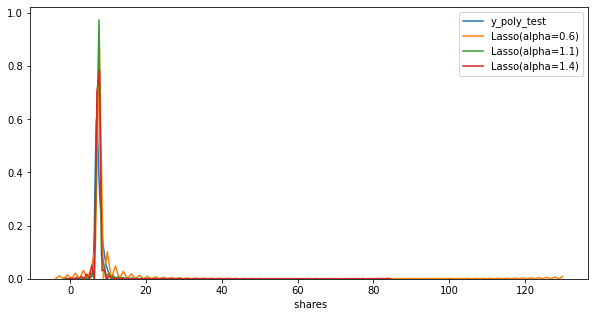

In [161]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(y_poly_test, hist=False, label="y_poly_test")
ax2 = sns.distplot(y_1_pred, hist=False, label="Lasso(alpha=0.6)", ax=ax1)
ax3 = sns.distplot(y_2_pred, hist=False, label="Lasso(alpha=1.1)", ax=ax1)
ax4 = sns.distplot(y_3_pred, hist=False, label="Lasso(alpha=1.4)", ax=ax1)
plt.show()
plt.close()

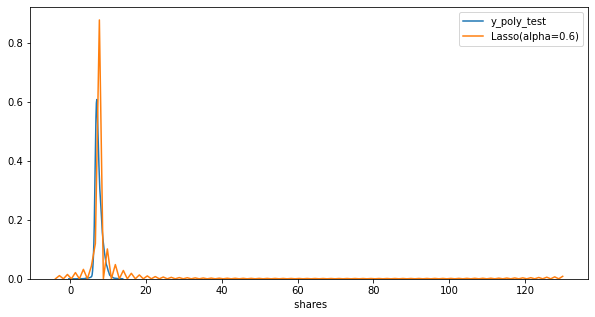

In [166]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(y_poly_test, hist=False, label="y_poly_test")
ax2 = sns.distplot(y_1_pred, hist=False, label="Lasso(alpha=0.6)", ax=ax1)
# ax3 = sns.distplot(y_2_pred, hist=False, label="Lasso(alpha=1.1)", ax=ax1)
# ax4 = sns.distplot(y_3_pred, hist=False, label="Lasso(alpha=1.4)", ax=ax1)
plt.show()
plt.close()

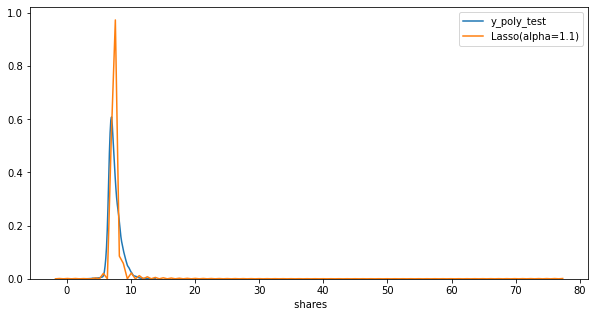

In [167]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(y_poly_test, hist=False, label="y_poly_test")
#ax2 = sns.distplot(y_1_pred, hist=False, label="Lasso(alpha=0.6)", ax=ax1)
ax3 = sns.distplot(y_2_pred, hist=False, label="Lasso(alpha=1.1)", ax=ax1)
# ax4 = sns.distplot(y_3_pred, hist=False, label="Lasso(alpha=1.4)", ax=ax1)
plt.show()
plt.close()

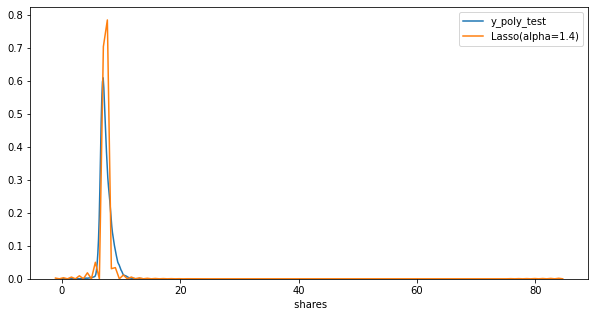

In [168]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(y_poly_test, hist=False, label="y_poly_test")
#ax2 = sns.distplot(y_1_pred, hist=False, label="Lasso(alpha=0.6)", ax=ax1)
# ax3 = sns.distplot(y_2_pred, hist=False, label="Lasso(alpha=1.1)", ax=ax1)
ax4 = sns.distplot(y_3_pred, hist=False, label="Lasso(alpha=1.4)", ax=ax1)
plt.show()
plt.close()

### Performance in cross-validation

In [169]:
Model_1 = Lasso(alpha=0.6)
Model_2 = Lasso(alpha=1.1)
Model_3 = Lasso(alpha=1.4)

In [170]:
r2_1 = np.mean(cross_val_score(Model_1, X_polynomial, y, scoring="r2", cv=4))
mse_1 = -np.mean(cross_val_score(Model_1, X_polynomial, y, scoring="neg_mean_squared_error", cv=4))
mae_1 = -np.mean(cross_val_score(Model_1, X_polynomial, y, scoring="neg_mean_absolute_error", cv=4))

print("r_squared", r2_1)
print("MSE", mse_1)
print("MAE", mae_1)

r_squared -2315509.2891916297
MSE 138669044871152.6
MAE 68349.00520033008


In [164]:
r2_2 = np.mean(cross_val_score(Model_2, X_polynomial, y, scoring="r2", cv=4))
mse_2 = -np.mean(cross_val_score(Model_2, X_polynomial, y, scoring="neg_mean_squared_error", cv=4))
mae_2= -np.mean(cross_val_score(Model_2, X_polynomial, y, scoring="neg_mean_absolute_error", cv=4))

print("r_squared", r2_2)
print("MSE", mse_2)
print("MAE", mae_2)

r_squared -4893.8738550450225
MSE 293871032973.8006
MAE 11998.210223501193


In [171]:
r2_3 = np.mean(cross_val_score(Model_3, X_polynomial, y, scoring="r2", cv=4))
mse_3 = -np.mean(cross_val_score(Model_3, X_polynomial, y, scoring="neg_mean_squared_error", cv=4))
mae_3= -np.mean(cross_val_score(Model_3, X_polynomial, y, scoring="neg_mean_absolute_error", cv=4))

print("r_squared", r2_3)
print("MSE", mse_3)
print("MAE", mae_3)

r_squared -73.0204969287614
MSE 5159176522.870532
MAE 9535.875517334229


### Performance in bootstrapping

In [172]:
Model_1 = Lasso(alpha=0.6)
Model_2 = Lasso(alpha=1.1)
Model_3 = Lasso(alpha=1.4)

In [177]:
R2_1 = []
MSE_1 = []
MAE_1 = []

for i in tqdm(range(350)):
    Model_1 = Lasso(alpha=0.6)
    X_resampled, y_resampled = resample(X_polynomial, y, n_samples=100)
    Model_1.fit(X_resampled, y_resampled)
    y_pred = Model_1.predict(X_resampled)
    MSE_1.append(met.mean_squared_error(y_resampled, y_pred))
    R2_1.append(met.r2_score(y_resampled, y_pred))
    MAE_1.append(met.mean_absolute_error(y_resampled, y_pred))

print("r_squared", np.mean(R2_1))
print("MSE", np.mean(MSE_1))
print("MAE", np.mean(MAE_1))

100%|██████████| 350/350 [00:50<00:00,  6.92it/s]

r_squared 0.9999994928591439
MSE 30.851734275974824
MAE 2.627144483588326


In [178]:
R2_2 = []
MSE_2 = []
MAE_2 = []

for i in tqdm(range(350)):
    Model_2 = Lasso(alpha=1.1)
    X_resampled, y_resampled = resample(X_polynomial, y, n_samples=100)
    Model_2.fit(X_resampled, y_resampled)
    y_pred = Model_2.predict(X_resampled)
    MSE_2.append(met.mean_squared_error(y_resampled, y_pred))
    R2_2.append(met.r2_score(y_resampled, y_pred))
    MAE_2.append(met.mean_absolute_error(y_resampled, y_pred))

print("r_squared", np.mean(R2_2))
print("MSE", np.mean(MSE_2))
print("MAE", np.mean(MAE_2))

100%|██████████| 350/350 [00:49<00:00,  7.03it/s]

r_squared 0.9999993534823397
MSE 24.30219782144901
MAE 2.659866722339942


In [179]:
R2_3 = []
MSE_3 = []
MAE_3 = []

for i in tqdm(range(350)):
    Model_3 = Lasso(alpha=1.4)
    X_resampled, y_resampled = resample(X_polynomial, y, n_samples=100)
    Model_3.fit(X_resampled, y_resampled)
    y_pred = Model_3.predict(X_resampled)
    MSE_1.append(met.mean_squared_error(y_resampled, y_pred))
    R2_1.append(met.r2_score(y_resampled, y_pred))
    MAE_1.append(met.mean_absolute_error(y_resampled, y_pred))

print("r_squared", np.mean(R2_1))
print("MSE", np.mean(MSE_1))
print("MAE", np.mean(MAE_1))

100%|██████████| 350/350 [00:50<00:00,  6.91it/s]

r_squared 0.9999994377575678
MSE 33.46030678845324
MAE 2.8476567149715764


## 3-c Use ANOVA to compare regression models to choose the best model
* Null hyphothesis : The group1 and group2 are meaningfully similar 

In [187]:
fstat, pval = f_oneway(y_poly_test, y_1_pred, y_2_pred, y_3_pred)

In [192]:
print(pval)
print(fstat)

0.7987396537738449
0.3367942923517168


### Post Hoc with Tukey

In [196]:
v = np.concatenate([y_poly_test, y_1_pred, y_2_pred, y_3_pred])

labels = ['test_y']*len(y_poly_test)+['y_1_pred']*len(y_1_pred)+['y_2_pred']*len(y_2_pred)+['y_3_pred']*len(y_3_pred)

tukey_results = pairwise_tukeyhsd(v, labels, 0.05)

In [195]:
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
test_y,y_1_pred,0.0117,0.7426,-0.0195,0.0429,False
test_y,y_2_pred,0.0078,0.9,-0.0234,0.039,False
test_y,y_3_pred,0.0085,0.8905,-0.0227,0.0397,False
y_1_pred,y_2_pred,-0.0039,0.9,-0.0351,0.0273,False
y_1_pred,y_3_pred,-0.0032,0.9,-0.0344,0.028,False
y_2_pred,y_3_pred,0.0007,0.9,-0.0305,0.0319,False


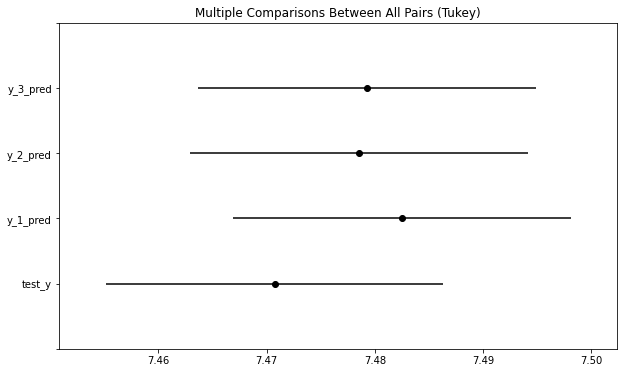

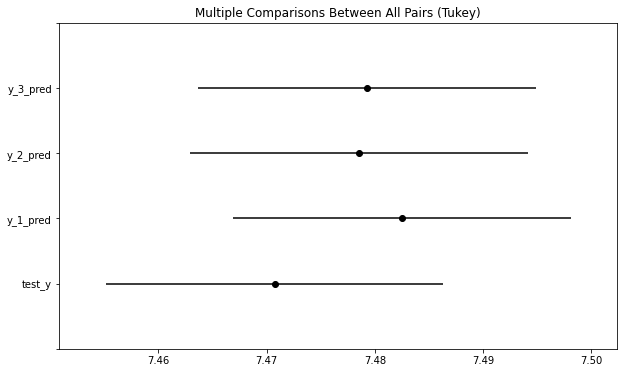

In [197]:
tukey_results.plot_simultaneous()